### **CNN + MLP Model in PyTorch**

### **Introduction**

The following model is intended for predicting house prices based on input images and corresponding numeric data such as beds, baths, etc. There are a few options for achieving this, and here we have chosen to use a hybrid CNN + MLP model. The CNN routinely handles the images, and the numeric data is handled by the MLP. The outputs of the MLP and the fully connected (FC) layers of the CNN are concatenated into another set of FC layers, which have a final output of a price prediction in the continuous range of $[0,1]$. The data used (2000 for training and 1000 for validation) is a cleaned subset of the original which is about 12000 data after cleaning. This was done mainly for convenience to speed up computing time. The model is also purposely lightweight in order to run efficiently with the goal of squeezing as much performance as possible out of the system, without large computational demands. Due to the small model size, a 2X performance improvement is obtained with GPU, but not much more. Note that 20 epochs takes about 4 minutes on GPU.

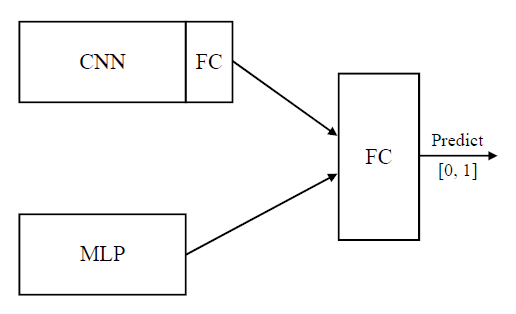

In [1]:
# -*- coding: utf-8 -*-

# Created on Wed Jun 9 2021

# @author: mbadal1996


# ====================================================
# CNN + MLP Model for Image + Numeric Data 
# ====================================================

# Comments:
# The following Python code is a hybrid CNN + MLP 
# model for combined image data + numeric features 
# (meta-data) which further describe the images.The 
# output of the model is a continuous float value in the 
# range [0,1] which is due to normalization of the 
# training label. In that sense it is a regression as 
# opposed to a classification. The original purpose of 
# the code was to make predictions on housing prices 
# (see So-Cal Housing in Kaggle) but this kind of hybrid
# model is useful for various other problems where 
# both images and numeric features are combined. In the 
# event that a binary or multi-class output is desired 
# (instead of a float value regression), then the final 
# output layer of the CNN+MLP should be modified for the 
# number of classes and then passed through a softmax 
# function.

# Original data from Kaggle at:

# https://www.kaggle.com/ted8080/house-prices-and-images-socal

# Useful content at PyTorch forum is acknowledged for 
# combining images and numeric data features. 

# -----------------------------------------------------

# IMPORTANT NOTE:
# When organizing data in folders to be input to 
# dataloader, it is important to keep in mind the 
# following for correct loading:

# 1) The train and validation data were separated into 
# their own folders by hand by class (one class: house) c
# alled 'socal_pics/train' and 'socal_pics/val'. That 
# means the sub-folder 'train' contains one folder: house.
# The same is true for the val data held in the folder 
# 'socal_pics/val'. So the organization looks like:

# socal_pics > train > house
# socal_pics > val > house

# Place the metadat CSV file in same folder as Python 
# script

# 2) The test data is organized differently since there 
# are no labels for those images. Instead, the test data
# are held in the folder 'socal_pics/test' where the 
# sub-folder here 'test' just contains one folder called
# 'test'. This is instead of the 'house' folder. So the
# organization looks like:

# socal_pics > test > test

# ======================================================

### **Imports and Parameters**

Below we perform standard imports, choose computing device, define parameters, and set a seed for reproducible results. Note that due to this, the shuffle feature in the data loader is chosen as False to prevent overriding seed. This also ensures that the numeric data loader (defined below) will be in step with the image loader. Approximate timer is also initialized.  

In [1]:
# ====================================================

# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# Pytorch
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

# Choose Device (GPU or CPU)
# dev = 'cuda'
dev = 'cpu'

# =====================================================
# Parameters

# Image Parameters
CH = 3  # number of channels
ratio = 1.5625  # width/height ratio to resize images
imagewidth = 157  # square dimension (size x size) 
imageheight = int(np.floor(imagewidth/ratio))
cropsize = imageheight
#cropsize = imagewidth


# Neural Net Parameters
learn_rate = 1e-3  
num_epochs = 20  # At least 20 epochs for 100x100 images
batch_size = 100  


# Seed for reproduceable random numbers (eg weights 
# and biases). NOTE: Seed will be overidden by using
# image transforms like random flip or setting 
# shuffle = True in data loader.
torch.manual_seed(1234)


# Start Timing Code  (only approximate)
tic = time.perf_counter()

# ======================================================

### **Image Transforms**

Below we set up transforms for the housing images which may or may not be of equal size (which they must be for the CNN). They also need to be reduced in resolution and cropped. Simply for convenience, a size of 100x100 pixels is chosen according to the parameters above. Note that 157/1.5625 = 100.

The images are not color normalized but this is a potentially useful addition that can be employed to improve model learning.

In [2]:
# ======================================================

# Image Transforms:
# Create transforms for training data augmentation. 
# In each epoch, random transforms will be applied 
# according to the Compose function. They are random 
# since we are explicitly choosing "Random" versions 
# of the transforms. To "increase the dataset" one 
# should run more epochs, since each epoch has new 
# random data.
# NOTE: Augmentation should only be for train data.
# NOTE: For augmentation transforms, best to use 
# larger batches

# Transform for training data
transform_train = transforms.Compose([
        transforms.Resize([imageheight, imagewidth]),
        transforms.CenterCrop(cropsize),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomRotation(degrees = (-20,20)), 
        #transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()])

# Transform for validation data
transform_val = transforms.Compose([
        transforms.Resize([imageheight, imagewidth]),
        transforms.CenterCrop(cropsize),
        transforms.ToTensor()])

# Transform for test data
#transform_test = transforms.Compose([
#        transforms.Resize([imageheight, imagewidth]),
#        transforms.CenterCrop(cropsize),
#        transforms.ToTensor()])

### **Import Numeric Data**

Below we import the CSV numeric data into a dataframe and then extract the needed values into appropriate tensors. Following this, the data is normalized on a scale of $[0,1]$. One can also standardize the data instead using e.g. the z-norm. Writing a function to handle the repetitive operations below would be a  useful modification to the code.

In [4]:
# ====================================================
# DATA IMPORT

# Import train,val, and test data and set up data 
# loader. Note that ImageFolder will organize data 
# according to class labels of the folders "house, 
# etc" as found in the train and val data folder.
# NOTE: When calling a specific image (such as 135) 
# from train data, the first XXX images are class 0,
# then the next YYY are class 1, and etc. if more 
# than one class existed (which is not the case here).

# Import CSV of Housing Data
# Read Data from File; Create Tensors for train,test,val
rawdata = \
pd.read_csv('../dataset/Mosaico/train.csv')
# pd.read_csv('../input/socal-data-cleaned/socal2_cleaned_mod.csv')

#  Import all columns in CSV
Xraw = np.column_stack((rawdata['mosaic_image'].values,
                        rawdata['zipcode'].values,
                        rawdata['bedrooms'].values,
                        rawdata['bathrooms'].values,
                        rawdata['area'].values,
                        rawdata['price'].values))

# ====================================================
# Prepare Training Data

# ====================================================
# NOTE: Normalization was done after splitting data.
# ====================================================

Xraw_train = Xraw[0:450,:]  # Get required train data
#city_data_train = Xraw_train[:,1]  # import city data
bdrm_data_train = Xraw_train[:,2]  # import bdrm data
bath_data_train = Xraw_train[:,3]  # import bath data
sqft_data_train = Xraw_train[:,4]  # import sqft data
yraw_true_train = Xraw_train[:,5]  # import price

# NORMALIZE DATA (COULD STANDARDIZE INSTEAD)
# Normalize data based to scale [0,1]. Could also 
# standardize as z = (x - mean)/stddev
#city_train_norm = city_data_train/np.max(city_data_train)
bdrm_train_norm = bdrm_data_train/np.max(bdrm_data_train)
bath_train_norm = bath_data_train/np.max(bath_data_train)
sqft_train_norm = sqft_data_train/np.max(sqft_data_train)
y_true_train_norm = yraw_true_train/np.max(yraw_true_train)

# Convert to torch tensor
#city_train = torch.from_numpy(city_train_norm).float()
bdrm_train = torch.from_numpy(bdrm_train_norm).float()
bath_train = torch.from_numpy(bath_train_norm).float()
sqft_train = torch.from_numpy(sqft_train_norm).float()
y_train = torch.from_numpy(y_true_train_norm).float()

# Combine sqft, bdrm, etc into one meta_data
meta_train = torch.stack((bdrm_train,bath_train,
                          sqft_train),dim=1)

# ===================================================
# Prepare Validation Data

# ===================================================
# NOTE: Normalization was done after splitting data. 
# ===================================================

Xraw_val = Xraw[2000:3000,:]  # Get required val data
#city_data_val = Xraw_val[:,1]  # import city data
bdrm_data_val = Xraw_val[:,2]  # import bdrm data
bath_data_val = Xraw_val[:,3]  # import bath data
sqft_data_val = Xraw_val[:,4]  # import sqft data
yraw_true_val = Xraw_val[:,5]  # import price data

# NORMALIZE DATA (COULD STANDARDIZE INSTEAD)
# Normalize data based to scale [0,1]. Could also 
# standardize as z = (x - mean)/stddev
#city_val_norm = city_data_val/np.max(city_data_val)
bdrm_val_norm = bdrm_data_val/np.max(bdrm_data_val)
bath_val_norm = bath_data_val/np.max(bath_data_val)
sqft_val_norm = sqft_data_val/np.max(sqft_data_val)
y_true_val_norm = yraw_true_val/np.max(yraw_true_val)

# Convert to torch tensor
#city_val = torch.from_numpy(city_val_norm).float()
bdrm_val = torch.from_numpy(bdrm_val_norm).float()
bath_val = torch.from_numpy(bath_val_norm).float()
sqft_val = torch.from_numpy(sqft_val_norm).float()
y_val = torch.from_numpy(y_true_val_norm).float()

# Combine sqft, bdrm, etc into one meta_data
meta_val = torch.stack((bdrm_val,bath_val,
                        sqft_val),dim=1)

# ================================================

KeyError: 'image_id'

### **Numeric Data Loaders**

Below we have created data loader functions for pulling out and storing batches of numeric data for train and validation. These batches will be of the same size as the image batches and correspond to the appropriate houses. It is fairly easy to combine into one function but here, for readability, there are two. 

In [5]:
# ================================================
# Generate batches of meta_data (house features)

# Metadata (House Feaures) Training Batches
def get_batch_train(batch_size,which_batch,
                    array_len=len(y_train)):
        
    num_batches = int(np.floor(array_len/batch_size))
    
    # Initialize lists
    batch_y = []
    batch_meta = []
    for i in range(num_batches+1):
        batch_y_train = \
            y_train[i*batch_size:(i+1)*batch_size]
        batch_meta_train = \
            meta_train[i*batch_size:(i+1)*batch_size,:]
        # NOTE: batch_y_train and batch_meta_train should
        # be enough to pull out batches directly. No need
        # to append to lists as below, but is convenient.
        batch_y.append(batch_y_train)
        batch_meta.append(batch_meta_train)
        
    # Call each batch from ydata_train and metadata_train
    ydata_train = torch.FloatTensor(batch_y[which_batch]) 
    metadata_train = torch.FloatTensor(batch_meta[which_batch])
    return ydata_train,metadata_train


# Metadata Validation Batches
def get_batch_val(batch_size,which_batch,
                  array_len=len(y_val)):
        
    num_batches = int(np.floor(array_len/batch_size))
    
    # Re-initialize lists
    batch_y = []
    batch_meta = []
    for i in range(num_batches+1):
        batch_y_val = \
            y_val[i*batch_size:(i+1)*batch_size]        
        batch_meta_val = \
            meta_val[i*batch_size:(i+1)*batch_size,:]
        # NOTE: batch_y_val and batch_meta_val should
        # be enough to pull out batches directly. No need
        # to append to lists as below, but is convenient.
        batch_y.append(batch_y_val)
        batch_meta.append(batch_meta_val)
        
    # Call each batch from ydata_val and metadata_val
    ydata_val = torch.FloatTensor(batch_y[which_batch]) 
    metadata_val = torch.FloatTensor(batch_meta[which_batch])
    return ydata_val,metadata_val


# ====================================================

### **Image Data Loaders**

Below we create data loaders for the images with shuffle = False, to maintain order with the numeric data loader above.

In [6]:
# ====================================================
# Create Image Data Loader for Train,Validation,Test

# Training Data
images_train = \
datasets.ImageFolder('../input/socal-data-cleaned/socal_pics/train',
                     transform=transform_train)
loader_train = \
torch.utils.data.DataLoader(images_train, shuffle=False, 
                            batch_size=batch_size)

# Validation Data
images_val = \
datasets.ImageFolder('../input/socal-data-cleaned/socal_pics/val',
                     transform=transform_val)
loader_val = \
torch.utils.data.DataLoader(images_val, shuffle=False, 
                            batch_size=batch_size)

# Testing Data
# Can add testing data loader as well if desired

### **CNN + MLP Hybrid Model**

Below we define the CNN+MLP model architecture. This particular model is set up for images of size 100x100. It was found that larger images were not necessarily helpful in improving performance.

In [7]:
# ==================================================
# CNN + MLP Model Architecture
# ==================================================

# Here we have used a combined CNN + MLP. The CNN 
# processes image data and the MLP is employed for 
# input/learning of numeric data/features. The 
# outputs of each are concatenated to form one 
# stream of data.

# NOTE NOTE NOTE: The CNN used in this problem 
# takes images of 100x100 pixels if linear input
# layer is X * 22 * 22 or 200x200 pixels 
# with X * 47 * 47.

# Two convolution network    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        # Image CNN
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv1 = torch.nn.Conv2d(3, 10, 5)
        self.conv2 = torch.nn.Conv2d(10, 10, 5)
        self.fc1 = torch.nn.Linear(10 * 22 * 22, 120)
        self.fc2 = torch.nn.Linear(120, 60)
        
        # Data MLP
        # 3 inputs (eg bdrm,bath,sqft) to MLP
        self.fc3 = torch.nn.Linear(3, 120)  
        self.fc4 = torch.nn.Linear(120, 60)

        # Cat outputs from CNN + MLP
        self.fc5 = torch.nn.Linear(60 + 60, 120)
        # 1 output (price) from CNN+MLP
        self.fc6 = torch.nn.Linear(120, 1)  
        # NOTE: output is trained as a regression value
        # (continuous), in the range [0,1].
        
    def forward(self, x1, x2):
        # Image CNN
        x1 = self.pool(F.relu(self.conv1(x1)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(-1, 10 * 22 * 22)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        
        # Data MLP
        x2 = x2.view(-1, 3) 
        x2 = F.relu(self.fc3(x2))
        x2 = F.relu(self.fc4(x2))
        
        # Cat outputs from CNN + MLP
        x3 = torch.cat((x1, x2), dim=1)
        x3 = F.relu(self.fc5(x3))
        x3 = self.fc6(x3)
        
        return x3

### **Loss Function and Optimizer**

Below we define an instance of the model class 'Net', choose the loss function, and the optimizer. The particular choice of MSE loss is due to the requirement of a regression (continuous) output from the model, which is the price prediction. 

In [8]:
    
# ==============================================
# ==============================================

# Call instance of CNN+MLP NN class
model = Net().to(dev)

# MSE loss func since NN output is contin. in [0,1]
loss_fn = torch.nn.MSELoss(reduction='mean')

# Optimizer used to train parameters
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learn_rate)

# ===============================================

### **Training Loop**

Below is the model training loop as well as the validation loop in each epoch. The average loss values and percent error are computed per epoch and stored in tensors for later plotting after training. 

In [9]:
# ===============================================

# Initialize tensor to store loss values
result_vals = torch.zeros(num_epochs,4)
count_train = 0  # Initialize Counter
count_val = 0
#X_test,y_true_test = loader_test

print(' ')
print('epoch  | loss_train  | loss_val  | err_train  | err_val')
print('-------------------------------------------------------')

error_train = torch.zeros(batch_size)
error_val = torch.zeros(batch_size)

for epoch in range(num_epochs):
    # New epoch begins
    running_loss_train = 0
    running_loss_val = 0
    running_error_train = 0
    running_error_val = 0
    num_batches_train = 0
    num_batches_val = 0
    count_train = 0
    count_val = 0
    j = 0  # Initialize batch counter
    k = 0  # Initialize batch counter
    
    model.train() # Set torch to train
    for X_train,_ in loader_train:
        X_train = X_train.to(dev) 
        # (X,y) is a mini-batch:
        # X size Nx3xHxW (N: batch_size, 3: three ch )
        # y size N
        
        # Get metadata in batches from function 
        ydata_train,metadata_train = \
            get_batch_train(batch_size,j)
        ydata_train,metadata_train = \
            ydata_train.to(dev),metadata_train.to(dev) 
        
        # reset gradients to zero
        optimizer.zero_grad()
        
        # run model and compute loss
        N,C,nX,nY = X_train.size()
        y_pred_train = model(X_train.view(N,C,nX,nY),
                             metadata_train)
        loss_train = loss_fn(y_pred_train.squeeze(),
                             ydata_train)
        
        # Back propagation
        loss_train.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Compute and update loss for entire training set
        running_loss_train += \
            loss_train.cpu().detach().numpy()
        num_batches_train += 1 
       
        for i in range(len(ydata_train)):
            error_train[i] = \
            abs(ydata_train[i].item() - \
            y_pred_train.squeeze()[i].item())/ydata_train[i].item()
        
        error_train_sum = sum(error_train)
        running_error_train = running_error_train + \
            error_train_sum
        
        j = j+1 # Step batch counter
    
        
    k = 0  # Re-initialize batch counter for validation
    model.eval()  # Set torch for evaluation
    for X_val,_ in loader_val:
        X_val = X_val.to(dev) 
        # (X,y) is a mini-batch:
        # X size Nx3xHxW (N: batch_size, 3: three ch )
        # y size N
        
        # Get metadata in batches from function
        ydata_val,metadata_val = \
            get_batch_val(batch_size,k)
        ydata_val,metadata_val = \
            ydata_val.to(dev),metadata_val.to(dev) 
        
        # run model and compute loss
        N,C,nX,nY = X_val.size()
        y_pred_val = model(X_val.view(N,C,nX,nY),
                           metadata_val)
        loss_val = loss_fn(y_pred_val.squeeze(),
                           ydata_val)
        
        # Compute and update loss for entire val set
        running_loss_val += \
            loss_val.cpu().detach().numpy()
        num_batches_val += 1 
        
        for i in range(len(ydata_val)):
            error_val[i] = \
            abs(ydata_val[i].item() - \
            y_pred_val.squeeze()[i].item())/ydata_val[i].item()
        
        
        error_val_sum = sum(error_val)
        running_error_val = running_error_val + \
            error_val_sum
        
        k = k+1  # Step batch counter

    ave_loss_train = running_loss_train/num_batches_train
    ave_loss_val = running_loss_val/num_batches_val
    ave_error_train = \
        (running_error_train.item()/len(y_train))*100
    ave_error_val = \
        (running_error_val.item()/len(y_val))*100


# ============================================

    
    # Store loss to tensor for plotting
    result_vals[epoch, 0] = ave_loss_train
    result_vals[epoch, 1] = ave_loss_val
    result_vals[epoch, 2] = ave_error_train
    result_vals[epoch, 3] = ave_error_val
    
    # Print loss every N epochs
    #if epoch % 2 == 1:
    print(epoch, '      ', round(ave_loss_train.item(),5), 
          '     ', round(ave_loss_val.item(),5), 
          '   ', round(ave_error_train,5),'  ', 
          round(ave_error_val,5))

# =================================================    

 
epoch  | loss_train  | loss_val  | err_train  | err_val
-------------------------------------------------------
0        0.09399       0.17662     124.35095    75.33382
1        0.05171       0.09053     55.11418    50.97061
2        0.04203       0.07711     52.66685    46.87334
3        0.03936       0.07154     51.87906    45.04146
4        0.03835       0.06959     52.63978    44.40047
5        0.03756       0.06462     52.32192    42.80874
6        0.03654       0.06173     51.21465    41.84162
7        0.03589       0.05959     51.504    41.19625
8        0.03532       0.05787     51.06573    40.6927
9        0.03491       0.05639     51.04565    40.2418
10        0.03453       0.05586     50.79059    40.207
11        0.03428       0.05476     50.62526    39.91112
12        0.03396       0.05411     50.40629    39.74893
13        0.03375       0.05383     50.29777    39.71849
14        0.03359       0.05349     50.18042    39.65468
15        0.03344       0.05371     50.10761  

### **Conclusion and Plotting Results**

Below, the computing time is obtained, followed by plotting the loss and percent error in house prediction. Note that with the given (relatively small) data set and limited features (beds, baths, and rooms), this model reaches about 49 percent error (train) and 40 percent error (validation). Obviously this result can be improved, but it is a reasonable starting point. To interpret, if a house costs 200K dollars, the error is about +/- 80K dollars. A better estimate (and better agreement between train and val) can be achieved with k-fold cross validation due to the small size of data set. More images/data can improve the overall accuracy as well if overfitting are kept under control. The CNN+MLP model may also benefit from employing batch-norm and drop-out. Finally, one important data feature which was not included in the CSV file is the house addresses. If these are converted to numeric GPS coordinates and used for training, it should have a significant impact on prediction accuracy since house price is well-known to be influenced by location. This update to the data is forthcoming.

 
Computing Time
259.437809301


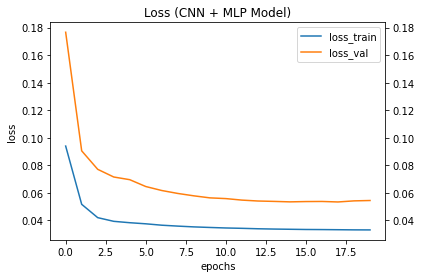

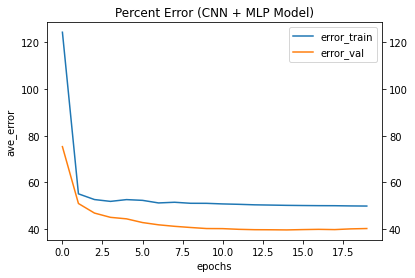

In [10]:
    
# =================================================    
# End Timing Code
toc = time.perf_counter()

# Measure Time
runtime = toc - tic

print(' ')
print('Computing Time')
print(runtime)


# ==============================================
# Plot Loss and Accuracy for train and val sets
# ==============================================

xvals = torch.linspace(0, num_epochs, num_epochs+1)
plt.plot(xvals[0:num_epochs].cpu().numpy(), 
         result_vals[:,0].cpu().detach().numpy())
plt.plot(xvals[0:num_epochs].cpu().numpy(), 
         result_vals[:,1].cpu().detach().numpy())
plt.legend(['loss_train', 'loss_val'], 
           loc='upper right')
#plt.xticks(xvals[0:num_epochs])
plt.title('Loss (CNN + MLP Model)')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.tick_params(right=True, labelright=True)
# plt.savefig('loss.pdf', bbox_inches='tight', dpi=2400)
plt.show()
#
#
# For plotting percent error (which needs to be added above)
plt.plot(xvals[0:num_epochs].cpu().numpy(), 
         result_vals[:,2].cpu().detach().numpy())
plt.plot(xvals[0:num_epochs].cpu().numpy(), 
         result_vals[:,3].cpu().detach().numpy())
plt.legend(['error_train', 'error_val'], 
           loc='upper right')
#plt.xticks(xvals[0:num_epochs])
plt.title('Percent Error (CNN + MLP Model)')
plt.xlabel('epochs')
plt.ylabel('ave_error')
plt.tick_params(right=True, labelright=True)
# plt.ylim(-0.15, 1.0)
plt.show()

## ==============================================